In [1]:
!pip install tensorflow
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 4.9 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import numpy as np
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [40]:
df1 = pd.read_csv("/content/target.csv",index_col = 0)
df2 = pd.read_csv("/content/dataset.csv",index_col = 0)

In [41]:
dataset = pd.concat([df2,df1], axis = 1)

In [42]:
X = dataset.drop(['infection'], axis = 1)

In [43]:
y = dataset['infection']

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, shuffle = True)

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((363, 52), (363,), (121, 52), (121,))

In [47]:
X_train['agenum'].dropna().sample(X_train['agenum'].isnull().sum(),random_state=0)


97     22.0
74     44.0
301    40.0
472    30.0
471    54.0
165    75.0
366    57.0
245    37.0
219    78.0
434    51.0
263    57.0
204    65.0
404    42.0
199    59.0
327    50.0
269    57.0
197    57.0
194    62.0
351    86.0
267    30.0
47     51.0
14     86.0
316    38.0
58     78.0
162    56.0
21     23.0
308    71.0
288    36.0
315    39.0
133    27.0
240    71.0
216    33.0
230    77.0
Name: agenum, dtype: float64

In [48]:
X_test['agenum'].dropna().sample(X_test['agenum'].isnull().sum(),random_state=0)

175    37.0
362    78.0
467    44.0
250    63.0
479    41.0
192    26.0
Name: agenum, dtype: float64

In [49]:
X_train[X_train['agenum'].isnull()].index
X_test[X_test['agenum'].isnull()].index

Int64Index([418, 427, 176, 425, 414, 426], dtype='int64')

In [50]:
def impute_nan(df,variable,mode):
    df[variable+"_mode"]=df[variable].fillna(mode)
    df[variable+"_random"]=df[variable]
    ##It will have the random sample to fill the nan value
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    ##pandas need to have same index in order to merge the dataset
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample

In [51]:
mode=X_train.agenum.mode()
mode=X_test.agenum.mode()

In [52]:
impute_nan(X_train,"agenum",mode)
impute_nan(X_test,"agenum",mode)


In [53]:
#X_test.head()
X_train.head()

,CXCL10,RPLP1,RPL13A,IFIT1,RPS18,IFI44L,RPS3A,RPS8,CXCL11,IFIT2,...,RPS12,FLT1,TOMM7,FPR3,RPL18A,MT-CO3,agenum,ctnum,agenum_mode,agenum_random
397,-0.330218,0.010943,-0.210595,0.042186,0.239706,-0.086893,-0.154712,0.084187,-0.214529,-0.107121,...,0.001392,-0.151642,-0.004632,-0.146563,0.013029,-0.131632,50.0,22.81,50.0,50.0
57,0.426675,0.201063,-0.024022,-0.013352,0.077604,0.044928,0.296684,-0.264555,-0.149196,0.093459,...,0.000115,0.019317,-0.070527,0.053134,0.179474,0.139848,62.0,19.35,62.0,62.0
286,-0.449942,-0.190835,0.044374,0.144829,-0.079280,-0.086654,-0.303872,-0.098651,0.259484,-0.207055,...,0.079855,-0.198764,0.233642,-0.184023,-0.180516,-0.115021,72.0,21.34,72.0,72.0
132,-0.385247,-0.206050,-0.239616,-0.120262,-0.137117,-0.310101,-0.280388,-0.231672,-0.151738,-0.266959,...,-0.186151,-0.235243,-0.019517,-0.233459,0.179042,0.272707,30.0,25.36,30.0,30.0
406,0.008941,-0.073164,-0.227340,-0.243443,-0.297489,-0.101534,0.102413,-0.061237,-0.281460,-0.125080,...,-0.118973,0.001721,0.051858,-0.027145,0.207186,0.133435,35.0,24.41,35.0,35.0


In [54]:
mode=X_train.ctnum.mode()
mode=X_test.ctnum.mode()
mode

0    20.24
1    25.43
dtype: float64

In [55]:
impute_nan(X_test,"ctnum",mode)
impute_nan(X_train,"ctnum",mode)


In [56]:
X_train.head()
X_test.head()

,CXCL10,RPLP1,RPL13A,IFIT1,RPS18,IFI44L,RPS3A,RPS8,CXCL11,IFIT2,...,TOMM7,FPR3,RPL18A,MT-CO3,agenum,ctnum,agenum_mode,agenum_random,ctnum_mode,ctnum_random
418,0.416963,0.181283,0.064580,-0.256586,-0.022616,-0.317925,0.376913,0.086584,-0.255495,0.096489,...,0.060116,0.060700,0.245187,0.187172,NaN,NaN,NaN,37.0,NaN,28.43
474,0.199633,0.206295,0.288382,-0.150975,0.394386,0.075909,-0.368996,0.323212,0.079250,0.018757,...,0.115995,-0.187145,0.095741,0.022223,24.0,NaN,24.0,24.0,NaN,20.44
181,-0.431797,-0.050736,0.030278,-0.117923,0.246983,-0.160531,-0.197276,0.083967,0.028719,-0.148602,...,0.037870,-0.148073,0.197723,0.057452,31.0,15.64,31.0,31.0,15.64,15.64
446,-0.379012,0.039950,0.292831,0.174339,0.256258,-0.020767,-0.409595,0.085018,0.011241,0.117534,...,-0.006608,-0.187606,-0.146445,-0.155532,22.0,NaN,22.0,22.0,NaN,24.17
297,0.451459,-0.048828,-0.089349,-0.151467,0.136524,-0.169697,0.116059,-0.235683,-0.048781,0.168612,...,-0.015781,0.221084,0.204374,0.190762,70.0,25.53,70.0,70.0,25.53,25.53


In [57]:
X_test.isnull().sum()
X_train.isnull().sum()


CXCL10            0
RPLP1             0
RPL13A            0
IFIT1             0
RPS18             0
IFI44L            0
RPS3A             0
RPS8              0
CXCL11            0
IFIT2             0
RPL13             0
PLA2G7            0
PRDX5             0
S100A6            0
IFIT3             0
RPL21             0
RPL3              0
OAS3              0
RPLP2             0
PCSK5             0
RPL10A            0
RPS5              0
RPL34             0
CASP17P           0
CCN5              0
RPLP0             0
RPS19             0
RPL26             0
SYNPO2L           0
RSAD2             0
IGFBP2            0
EEF2              0
ATP5IF1           0
RPL35             0
RPS7              0
OAZ1              0
RPL37             0
RPS17             0
RPL32             0
XAF1              0
OAS2              0
RPL7              0
ATP5F1E           0
OPRM1             0
RPS12             0
FLT1              0
TOMM7             0
FPR3              0
RPL18A            0
MT-CO3            0


In [58]:
X_train = X_train.drop(['agenum','ctnum','agenum_mode','ctnum_mode'], axis = 1)


In [59]:
X_test = X_test.drop(['agenum','ctnum','agenum_mode','ctnum_mode'], axis = 1)

In [60]:
X_test.isnull().sum()

CXCL10           0
RPLP1            0
RPL13A           0
IFIT1            0
RPS18            0
IFI44L           0
RPS3A            0
RPS8             0
CXCL11           0
IFIT2            0
RPL13            0
PLA2G7           0
PRDX5            0
S100A6           0
IFIT3            0
RPL21            0
RPL3             0
OAS3             0
RPLP2            0
PCSK5            0
RPL10A           0
RPS5             0
RPL34            0
CASP17P          0
CCN5             0
RPLP0            0
RPS19            0
RPL26            0
SYNPO2L          0
RSAD2            0
IGFBP2           0
EEF2             0
ATP5IF1          0
RPL35            0
RPS7             0
OAZ1             0
RPL37            0
RPS17            0
RPL32            0
XAF1             0
OAS2             0
RPL7             0
ATP5F1E          0
OPRM1            0
RPS12            0
FLT1             0
TOMM7            0
FPR3             0
RPL18A           0
MT-CO3           0
agenum_random    0
ctnum_random     0
dtype: int64

In [61]:
X_train.isnull().sum()

CXCL10           0
RPLP1            0
RPL13A           0
IFIT1            0
RPS18            0
IFI44L           0
RPS3A            0
RPS8             0
CXCL11           0
IFIT2            0
RPL13            0
PLA2G7           0
PRDX5            0
S100A6           0
IFIT3            0
RPL21            0
RPL3             0
OAS3             0
RPLP2            0
PCSK5            0
RPL10A           0
RPS5             0
RPL34            0
CASP17P          0
CCN5             0
RPLP0            0
RPS19            0
RPL26            0
SYNPO2L          0
RSAD2            0
IGFBP2           0
EEF2             0
ATP5IF1          0
RPL35            0
RPS7             0
OAZ1             0
RPL37            0
RPS17            0
RPL32            0
XAF1             0
OAS2             0
RPL7             0
ATP5F1E          0
OPRM1            0
RPS12            0
FLT1             0
TOMM7            0
FPR3             0
RPL18A           0
MT-CO3           0
agenum_random    0
ctnum_random     0
dtype: int64

In [62]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
from collections import Counter
# summarize class distribution
counter = Counter(y_train)
print(counter)

Counter({1: 326, 0: 37})


In [64]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [65]:
X_train.shape, y_train.shape,X_test.shape,y_test.shape

((652, 52), (652,), (121, 52), (121,))

In [66]:
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0.0)
var_thres.fit(X_train)

VarianceThreshold()

In [67]:
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [68]:
X_train.columns[var_thres.get_support()]

Index(['CXCL10', 'RPLP1', 'RPL13A', 'IFIT1', 'RPS18', 'IFI44L', 'RPS3A',
       'RPS8', 'CXCL11', 'IFIT2', 'RPL13', 'PLA2G7', 'PRDX5', 'S100A6',
       'IFIT3', 'RPL21', 'RPL3', 'OAS3', 'RPLP2', 'PCSK5', 'RPL10A', 'RPS5',
       'RPL34', 'CASP17P', 'CCN5', 'RPLP0', 'RPS19', 'RPL26', 'SYNPO2L',
       'RSAD2', 'IGFBP2', 'EEF2', 'ATP5IF1', 'RPL35', 'RPS7', 'OAZ1', 'RPL37',
       'RPS17', 'RPL32', 'XAF1', 'OAS2', 'RPL7', 'ATP5F1E', 'OPRM1', 'RPS12',
       'FLT1', 'TOMM7', 'FPR3', 'RPL18A', 'MT-CO3', 'agenum_random',
       'ctnum_random'],
      dtype='object')

In [69]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[var_thres.get_support()]]

print(len(constant_columns))

0


In [70]:
for feature in constant_columns:
     print(feature)

In [71]:
X_train.drop(constant_columns,axis=1)


,CXCL10,RPLP1,RPL13A,IFIT1,RPS18,IFI44L,RPS3A,RPS8,CXCL11,IFIT2,...,ATP5F1E,OPRM1,RPS12,FLT1,TOMM7,FPR3,RPL18A,MT-CO3,agenum_random,ctnum_random
0,-0.330218,0.010943,-0.210595,0.042186,0.239706,-0.086893,-0.154712,0.084187,-0.214529,-0.107121,...,-0.136621,-0.065396,0.001392,-0.151642,-0.004632,-0.146563,0.013029,-0.131632,50.000000,22.810000
1,0.426675,0.201063,-0.024022,-0.013352,0.077604,0.044928,0.296684,-0.264555,-0.149196,0.093459,...,0.094898,0.112702,0.000115,0.019317,-0.070527,0.053134,0.179474,0.139848,62.000000,19.350000
2,-0.449942,-0.190835,0.044374,0.144829,-0.079280,-0.086654,-0.303872,-0.098651,0.259484,-0.207055,...,-0.203448,0.122401,0.079855,-0.198764,0.233642,-0.184023,-0.180516,-0.115021,72.000000,21.340000
3,-0.385247,-0.206050,-0.239616,-0.120262,-0.137117,-0.310101,-0.280388,-0.231672,-0.151738,-0.266959,...,-0.175444,0.007655,-0.186151,-0.235243,-0.019517,-0.233459,0.179042,0.272707,30.000000,25.360000
4,0.008941,-0.073164,-0.227340,-0.243443,-0.297489,-0.101534,0.102413,-0.061237,-0.281460,-0.125080,...,-0.123866,-0.066818,-0.118973,0.001721,0.051858,-0.027145,0.207186,0.133435,35.000000,24.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,-0.099775,0.089812,0.091837,-0.373494,0.176285,-0.237958,-0.315272,0.266815,-0.242458,-0.061355,...,-0.200334,0.039065,0.135400,-0.383394,0.000682,-0.261809,0.088650,0.156539,27.771503,20.990434
648,-0.099574,0.058581,0.248456,-0.020989,0.271847,0.278935,-0.350071,0.407973,-0.046183,0.066927,...,-0.131827,0.172456,0.286375,-0.398050,-0.116554,-0.318720,-0.155950,-0.302727,74.775859,24.532069
649,-0.373046,-0.197800,-0.082013,-0.178689,-0.118582,-0.159245,-0.328160,-0.085338,-0.213208,-0.204770,...,-0.255738,-0.107155,-0.049922,-0.288739,0.083952,-0.162083,0.167016,0.151176,77.141925,23.072447
650,0.049389,0.037630,0.099519,-0.113847,0.106405,-0.147301,-0.166843,0.171233,-0.240877,-0.031845,...,-0.059830,0.156882,0.137829,-0.313901,-0.075803,-0.201835,-0.055160,-0.091014,31.235494,21.862158


In [72]:
X_train.corr()

,CXCL10,RPLP1,RPL13A,IFIT1,RPS18,IFI44L,RPS3A,RPS8,CXCL11,IFIT2,...,ATP5F1E,OPRM1,RPS12,FLT1,TOMM7,FPR3,RPL18A,MT-CO3,agenum_random,ctnum_random
CXCL10,1.000000,0.681766,0.382222,0.122720,0.192882,0.449971,0.753223,0.012936,0.085615,0.689447,...,0.728491,-0.100592,-0.161079,0.513718,-0.279534,0.549255,0.006990,-0.041044,-0.082128,-0.029673
RPLP1,0.681766,1.000000,0.698437,0.298701,0.504973,0.644216,0.369438,0.495899,0.197213,0.763984,...,0.504691,0.077277,0.339311,0.187989,-0.480278,0.155154,-0.226641,-0.306395,-0.088215,-0.047805
RPL13A,0.382222,0.698437,1.000000,0.262261,0.574143,0.550069,0.035740,0.574464,0.069375,0.598450,...,0.224028,0.325352,0.576312,-0.120354,-0.480701,-0.157909,-0.341360,-0.427807,-0.114273,-0.104178
IFIT1,0.122720,0.298701,0.262261,1.000000,0.163130,0.688391,0.200057,0.384862,0.717883,0.490985,...,0.383699,0.065048,0.410617,0.288706,-0.463368,0.108538,-0.738524,-0.500423,-0.155883,-0.050771
RPS18,0.192882,0.504973,0.574143,0.163130,1.000000,0.285834,-0.102813,0.629495,0.109064,0.437159,...,0.073118,0.131486,0.479604,-0.166836,-0.325230,-0.259049,-0.178079,-0.291995,-0.118431,0.018403
IFI44L,0.449971,0.644216,0.550069,0.688391,0.285834,1.000000,0.282517,0.465635,0.482312,0.649699,...,0.484127,0.119093,0.393992,0.225909,-0.525806,0.124641,-0.623231,-0.468618,-0.144654,-0.146180
RPS3A,0.753223,0.369438,0.035740,0.200057,-0.102813,0.282517,1.000000,-0.218491,0.228841,0.543390,...,0.828736,-0.365283,-0.382299,0.835346,-0.178048,0.792155,0.030948,0.143728,-0.076378,-0.121349
RPS8,0.012936,0.495899,0.574464,0.384862,0.629495,0.465635,-0.218491,1.000000,0.328233,0.453278,...,-0.000390,0.121090,0.707367,-0.147572,-0.501728,-0.350004,-0.506353,-0.427029,-0.169179,-0.071826
CXCL11,0.085615,0.197213,0.069375,0.717883,0.109064,0.482312,0.228841,0.328233,1.000000,0.389658,...,0.357480,-0.224390,0.198485,0.437080,-0.190861,0.273777,-0.511226,-0.133850,-0.167273,-0.136740
IFIT2,0.689447,0.763984,0.598450,0.490985,0.437159,0.649699,0.543390,0.453278,0.389658,1.000000,...,0.661665,-0.129783,0.244702,0.468421,-0.518243,0.366284,-0.333572,-0.195787,-0.097396,-0.093228


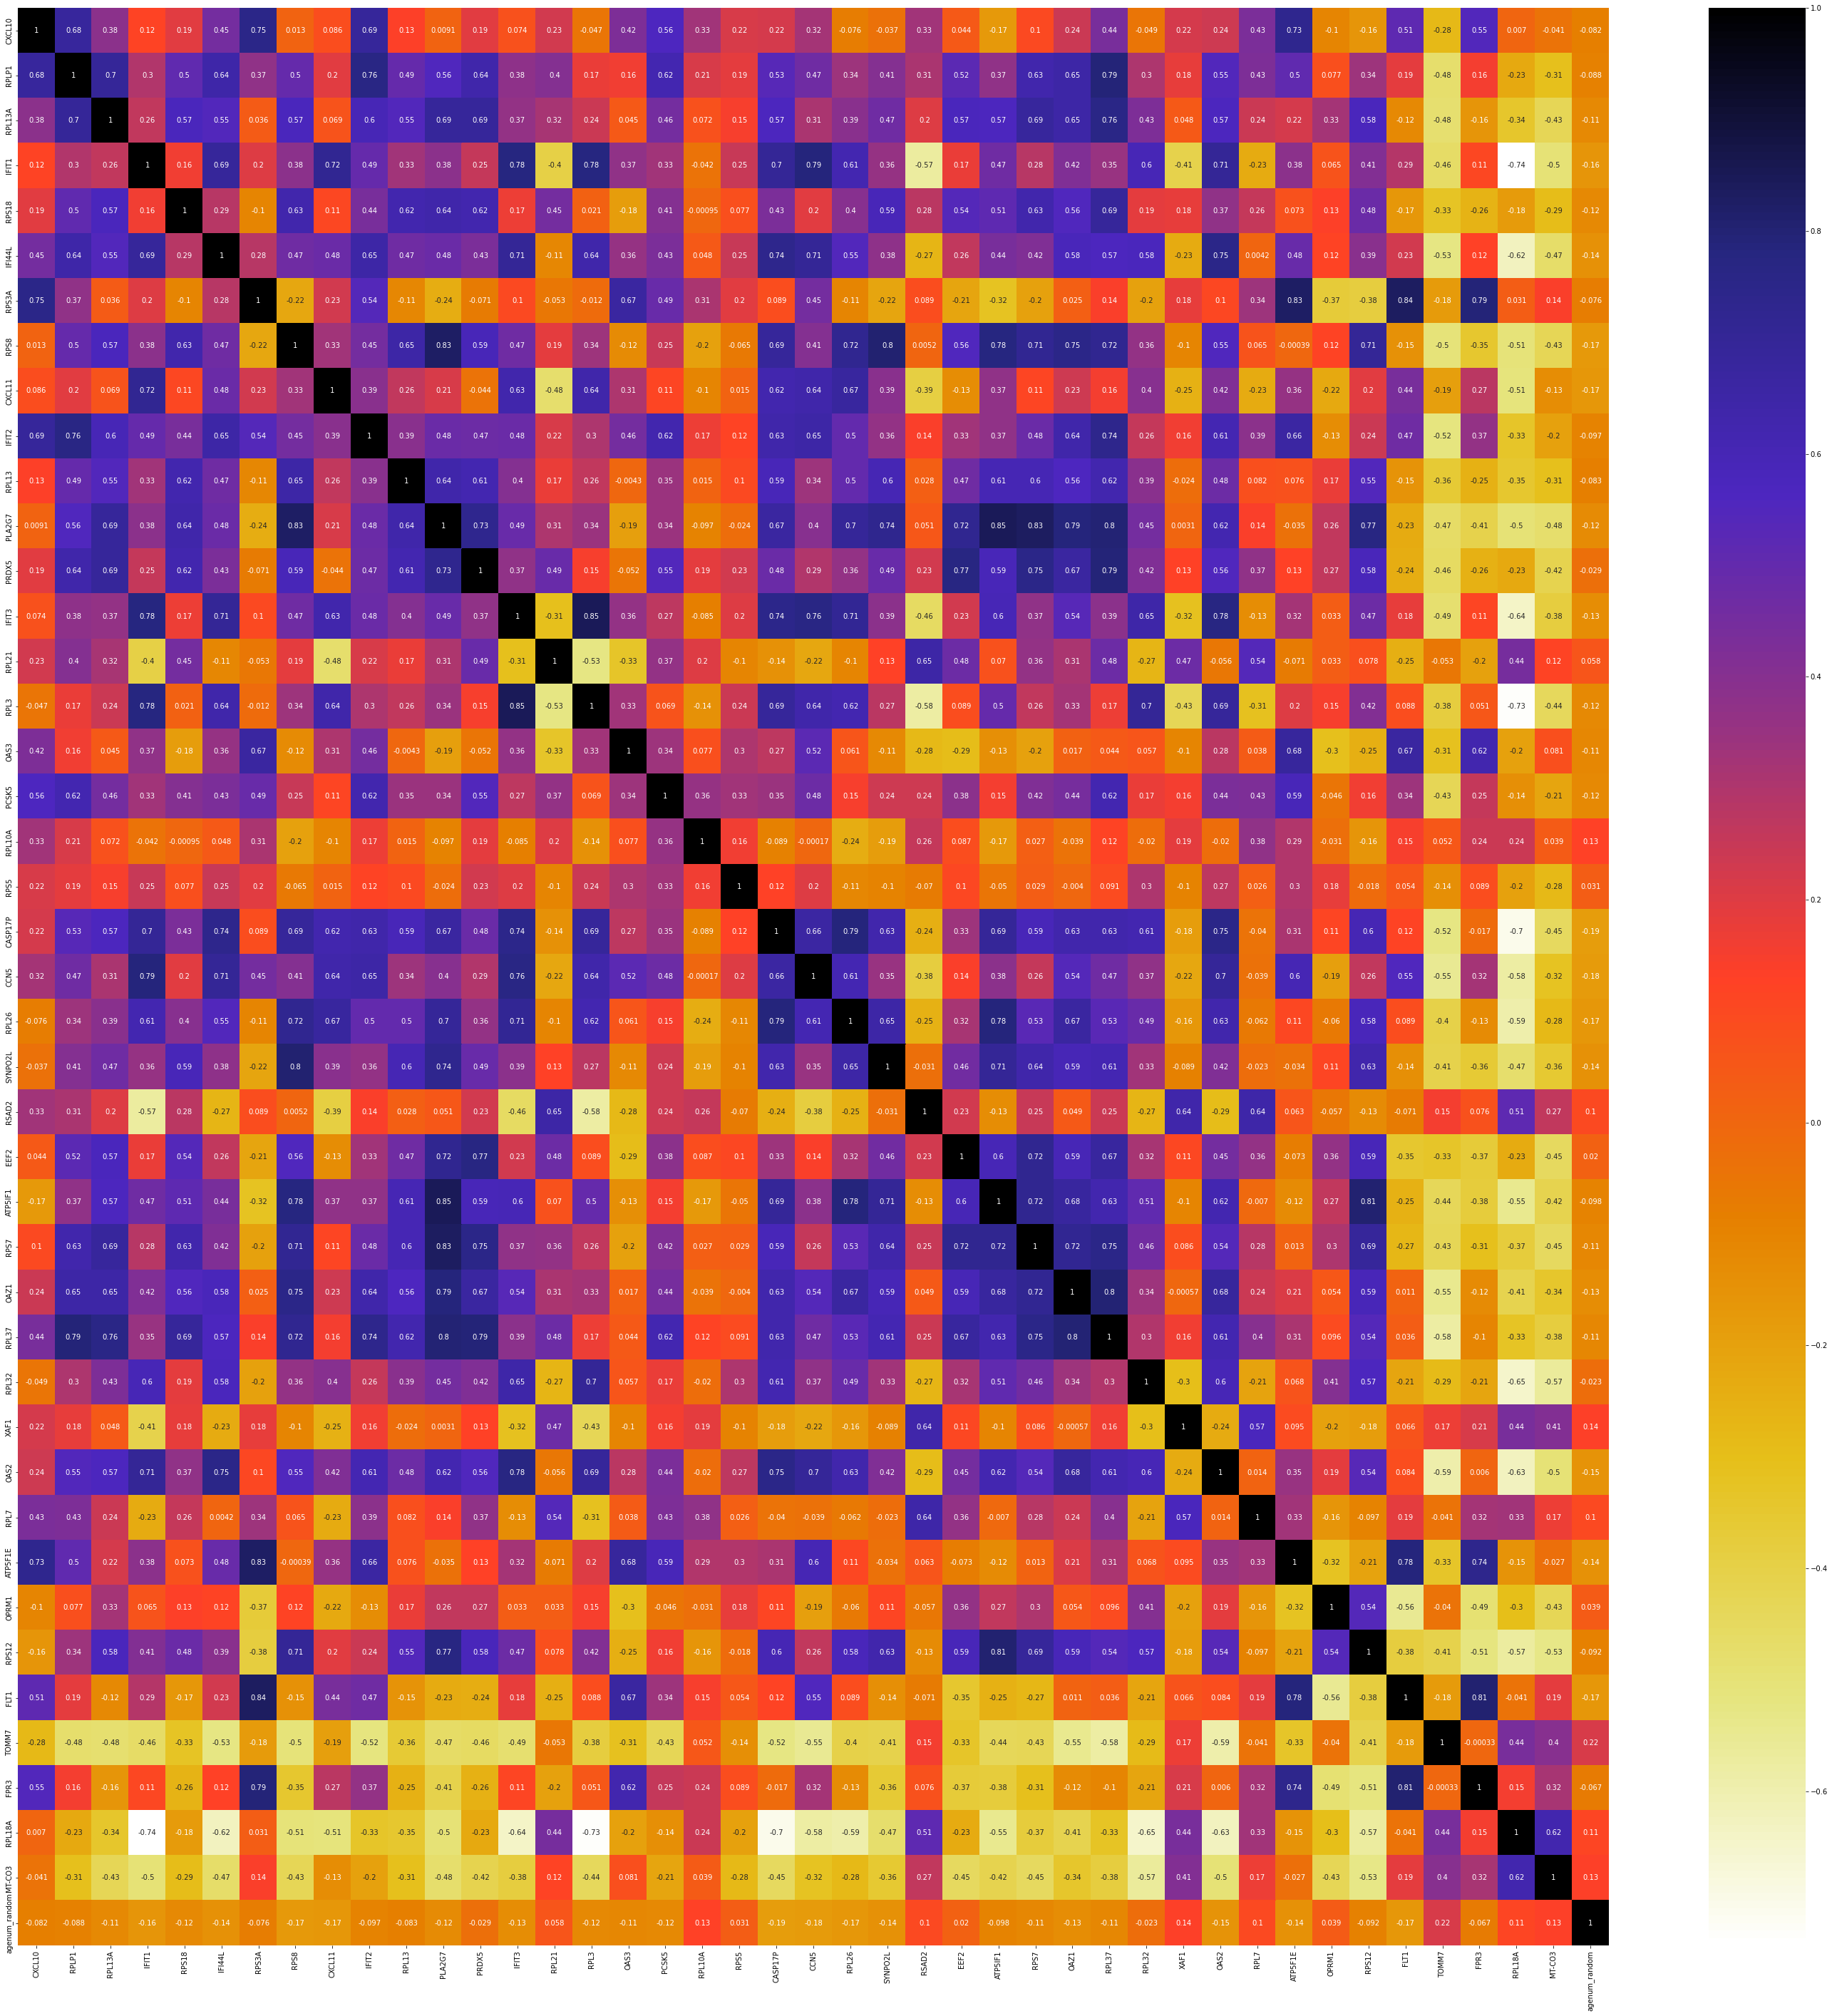

In [140]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(50,50))
cor = X_train.corr()
sns_plot = sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
fig = sns_plot.get_figure()
fig.savefig("/content/heatmap.png")
plt.show()

In [74]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr


In [77]:
corr_features = correlation(X_train, 0.85)
len(set(corr_features))
corr_features

{'IGFBP2', 'RPL34', 'RPL35', 'RPLP0', 'RPLP2', 'RPS17', 'RPS19', 'S100A6'}

In [78]:
X_train = X_train.drop(corr_features,axis=1)
X_test = X_test.drop(corr_features,axis=1)

In [79]:
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.05382049, 0.05163197, 0.10600529, 0.07234855, 0.06200149,
       0.07912068, 0.10389557, 0.07548574, 0.05723998, 0.06492303,
       0.07553109, 0.14959083, 0.06606649, 0.04800694, 0.09203851,
       0.06870795, 0.27864787, 0.04101786, 0.06865957, 0.15976995,
       0.02239533, 0.01420435, 0.05501016, 0.02868357, 0.06035301,
       0.1590282 , 0.09538386, 0.15053931, 0.08439738, 0.11728607,
       0.06238535, 0.03349223, 0.0183882 , 0.07271428, 0.10123556,
       0.05458153, 0.09140055, 0.11721571, 0.01869174, 0.16894034,
       0.05336699, 0.0430318 , 0.28754865, 0.00787883])

In [80]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

agenum_random    0.287549
OAS3             0.278648
FPR3             0.168940
RPS5             0.159770
EEF2             0.159028
RPS7             0.150539
PLA2G7           0.149591
RPL37            0.117286
FLT1             0.117216
RPL13A           0.106005
RPS3A            0.103896
ATP5F1E          0.101236
ATP5IF1          0.095384
RPL21            0.092039
RPS12            0.091401
OAZ1             0.084397
IFI44L           0.079121
RPL13            0.075531
RPS8             0.075486
RPL7             0.072714
IFIT1            0.072349
RPL3             0.068708
RPL10A           0.068660
PRDX5            0.066066
IFIT2            0.064923
RPL32            0.062385
RPS18            0.062001
RSAD2            0.060353
CXCL11           0.057240
RPL26            0.055010
OPRM1            0.054582
CXCL10           0.053820
RPL18A           0.053367
RPLP1            0.051632
IFIT3            0.048007
MT-CO3           0.043032
PCSK5            0.041018
XAF1             0.033492
SYNPO2L     

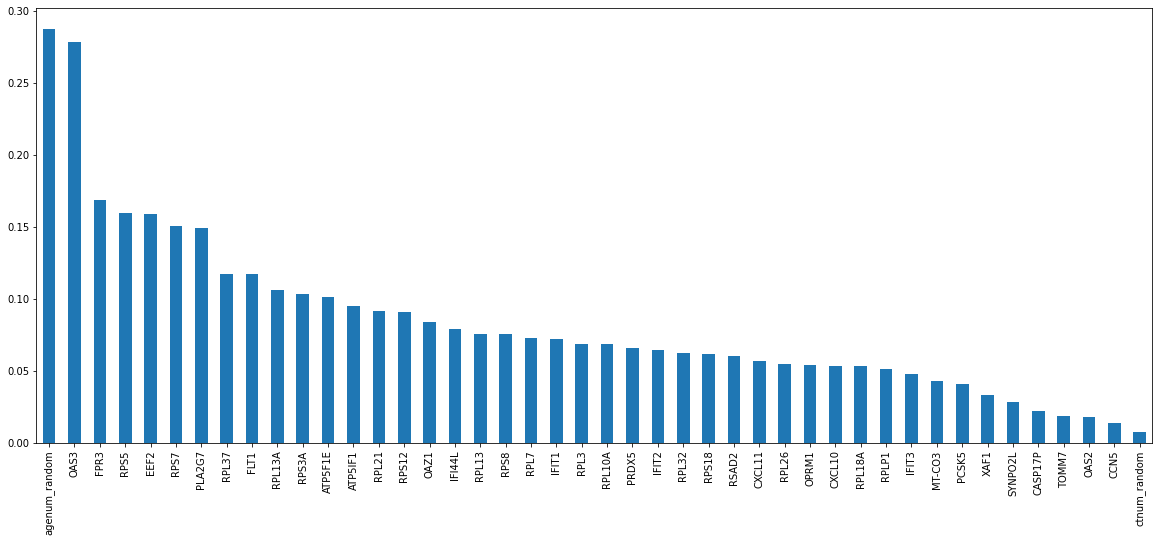

In [81]:
#let's plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [82]:
X_train = X_train.drop(['ctnum_random'], axis = 1)
X_test = X_test.drop(['ctnum_random'], axis = 1)

In [83]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((652, 43), (121, 43), (652,), (121,))

In [84]:
!pip install Xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [85]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score,precision_score,f1_score
import xgboost as xgb

In [86]:
scaler = StandardScaler()

In [87]:
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[ 1.7625154 ,  1.33774747,  0.29410954, ...,  1.57832893,
         0.88803896, -0.7856436 ],
       [ 0.94909408,  1.51699342,  1.63232845, ...,  0.48284522,
         0.09146095, -1.48538328],
       [-1.41421854, -0.32495476,  0.08900446, ...,  1.23040241,
         0.2615921 , -1.10860038],
       ...,
       [ 0.52175198, -0.08478754,  0.56763482, ...,  1.34729826,
         0.55825137,  1.09827094],
       [-1.28941479, -2.38423159, -2.78886467, ...,  1.49841462,
         1.6626579 ,  0.72148803],
       [ 2.14604304,  1.08907621, -0.09196956, ...,  1.26359326,
         0.55148437,  1.2059232 ]])

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [90]:
y_pred_lr = lr.predict(X_test)

In [91]:
from sklearn.metrics import *

In [92]:
acc_lr = accuracy_score(y_test,y_pred_lr)

In [97]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)


In [98]:
acc_nb = accuracy_score(y_test,y_pred_nb)

In [99]:
rf = RandomForestClassifier(max_features=5, n_estimators=500)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [100]:
acc_rf = accuracy_score(y_test,y_pred_rf)

In [101]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier()

In [102]:
y_pred_xg = xgb.predict(X_test)

In [103]:
acc_xg = accuracy_score(y_test,y_pred_xg)

In [104]:
model = Sequential()
model.add(Dense(60, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [105]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [106]:
history = model.fit(X_train,y_train,batch_size=50,epochs=100,verbose=1,validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 1s 27ms/step - loss: 1.0731 - accuracy: 0.6008 - val_loss: 0.3774 - val_accuracy: 1.0000
Epoch 2/100
11/11 [==============================] - 0s 5ms/step - loss: 0.7198 - accuracy: 0.5182 - val_loss: 1.3591 - val_accuracy: 0.0000e+00
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6543 - accuracy: 0.6315 - val_loss: 0.8532 - val_accuracy: 0.0840
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6284 - accuracy: 0.6891 - val_loss: 0.9103 - val_accuracy: 0.0916
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.6101 - accuracy: 0.6852 - val_loss: 0.9036 - val_accuracy: 0.1527
Epoch 6/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5930 - accuracy: 0.7044 - val_loss: 0.8272 - val_accuracy: 0.2824
Epoch 7/100
11/11 [==============================] - 0s 5ms/step - loss: 0.5770 - accuracy: 0.7063 - val_loss: 0.7452 - val_accuracy: 0.5115
Epoch 8/

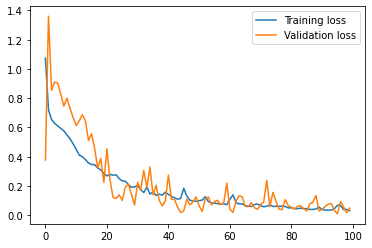

In [107]:
#plt.plot(history.history['accuracy'], label = "Train Accuracy")
#plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

In [108]:
y_pred_prob = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [109]:
y_pred_mlp = np.array([ 1 if i > 0.5 else 0 for i in y_pred_prob]) 

In [110]:
acc_mlp = accuracy_score(y_true = y_test, y_pred = y_pred_mlp)
con_mlp = confusion_matrix(y_true = y_test, y_pred = y_pred_mlp)
f1_mlp = f1_score(y_true = y_test, y_pred = y_pred_mlp)
rec_mlp = recall_score(y_true = y_test, y_pred = y_pred_mlp)
pre_mlp = precision_score(y_test,y_pred_mlp)
auc_mlp = roc_auc_score(y_test, y_pred_prob)
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, y_pred_prob)

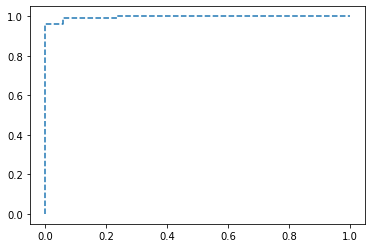

In [111]:
plt.plot(mlp_fpr, mlp_tpr, linestyle='--', label='MLP prediction (AUROC = %0.3f)' % auc_mlp)

In [112]:
mlp_precision, mlp_recall, _ = precision_recall_curve(y_test, y_pred_prob)

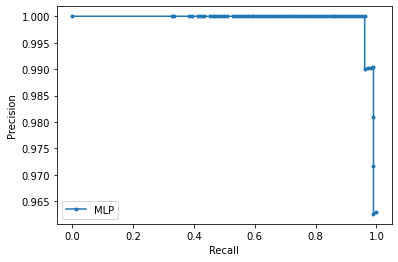

In [113]:
plt.figure(figsize=(6,4))
plt.plot(mlp_recall, mlp_precision, marker='.', label='MLP')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [115]:
result = pd.DataFrame()
result['Actual Label'] = y_test
result['Logistic Regression Prediction'] = y_pred_lr
result['Naive bayes Prediction'] = y_pred_nb
result['Random forest Prediction'] = y_pred_rf
result['XgBoost Prediction'] = y_pred_xg
result['MLP Prediction'] = y_pred_mlp

In [116]:
#print('Precision score of Logistic regression' ,
pre_lr = precision_score(y_test,y_pred_lr)
#print('Precision score of Naive Bayes' ,
pre_nb = precision_score(y_test,y_pred_nb)
#print('Precision score of Random Forest' ,
pre_rf = precision_score(y_test,y_pred_rf)
#print('Precision score of XgBoost' ,
pre_xg = precision_score(y_test,y_pred_xg)
#print('Precision score of MLP' ,
pre_mlp = precision_score(y_test,y_pred_mlp)

In [117]:
#print('Recall of Logistic Regression',
rec_lr = recall_score(y_test,y_pred_lr)
#print('Recall of Naive Bayes',
rec_nb =  recall_score(y_test,y_pred_nb)
#print('Recall of Random Forest',
rec_rf =  recall_score(y_test,y_pred_rf)
#print('Recall of XgBoost',
rec_xg =  recall_score(y_test,y_pred_xg)
#print('Precision score of MLP' ,
rec_mlp =  recall_score(y_test,y_pred_mlp)

In [118]:
#print('Recall of Logistic Regression',
f1_lr = f1_score(y_test,y_pred_lr)
#print('Recall of Naive Bayes',
f1_nb =  f1_score(y_test,y_pred_nb)
#print('Recall of Random Forest',
f1_rf =  f1_score(y_test,y_pred_rf)
#print('Recall of XgBoost',
f1_xg =  f1_score(y_test,y_pred_xg)
#print('Precision score of MLP' ,
f1_mlp =  f1_score(y_test,y_pred_mlp)

In [139]:
r_probs = [0 for _ in range(len(y_test))]
rf_probs = rf.predict_proba(X_test)
nb_probs = nb.predict_proba(X_test)
xg_probs = xgb.predict_proba(X_test)
lr_probs = lr.predict_proba(X_test)

In [123]:
rf_probs = rf_probs[:, 1]
nb_probs = nb_probs[:, 1]
lr_probs = lr_probs[:, 1]
xg_probs = xg_probs[:, 1]

In [125]:
r_auc = roc_auc_score(y_test, r_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
xg_auc = roc_auc_score(y_test, xg_probs)
lr_auc = roc_auc_score(y_test, lr_probs)


In [126]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
xg_fpr, xg_tpr, _ = roc_curve(y_test, xg_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

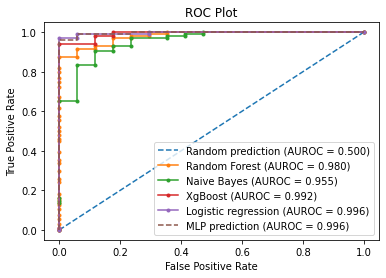

In [137]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)
plt.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes (AUROC = %0.3f)' % nb_auc)
plt.plot(xg_fpr, xg_tpr, marker='.', label='XgBoost (AUROC = %0.3f)' % xg_auc)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic regression (AUROC = %0.3f)' % lr_auc)
plt.plot(mlp_fpr, mlp_tpr, linestyle='--', label='MLP prediction (AUROC = %0.3f)' % auc_mlp)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() 
plt.savefig("/content/AUROC_CURVE.png", dpi=800)# 
# Show plot
plt.show()

In [130]:
result = pd.DataFrame()
result['Algorithm'] = ['XgBoost','RandomForest','LogisticRegression', 'Naive bayes', 'Multilayer perceptron']
result['Accuracy score'] = [acc_xg,acc_rf,acc_lr,acc_nb,acc_mlp]
result['Precision'] = [pre_xg,pre_rf,pre_lr,pre_nb,pre_mlp]
result['Recall'] = [rec_xg,rec_rf,rec_lr,rec_nb,rec_mlp]
result['F1 score'] = [f1_xg,f1_rf,f1_lr,f1_nb,f1_mlp]
result['AUROC'] = [xg_auc,rf_auc,lr_auc,nb_auc, auc_mlp]

In [131]:
result

,Algorithm,Accuracy score,Precision,Recall,F1 score,AUROC
0,XgBoost,0.942149,0.989899,0.942308,0.965517,0.992081
1,RandomForest,0.950413,0.962264,0.980769,0.971429,0.980204
2,LogisticRegression,0.966942,0.990196,0.971154,0.980583,0.996041
3,Naive bayes,0.909091,0.960396,0.932692,0.946341,0.955317
4,Multilayer perceptron,0.975207,0.980952,0.990385,0.985646,0.996041


In [132]:
result.to_csv('/content/performance table.csv')